In [2]:
require(data.table)
require(tidyverse)

## 1. Read data 

In [3]:
dat.mat <- fread('../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts.txt')
dim(dat.mat)
head(dat.mat)
#dat.mat$cell <- NULL #no need cell id 

[1] 19425849        7

seq,start,end,gene,cluster,cell,transcript.idx
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,1
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,1
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,1
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,1
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,1
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,1


 Concepts: 
1. `promoter region`: -500bp + 500bp for all TSS in gencode 
2. `promoter Peaks`: peaks that overlap promoter region

In [4]:
# get all cells 
dat.all.cells <- table((fread('../dat/output.umap.ab.filtered.csv'))$cluster) # table for all cells
dat.all.cells


alpha_1 alpha_2  beta_1  beta_2 
   4266    1328    4354    2816 

## 2. Fisher's exact test at transcript level 

As long as there is any promoter peaks in that cell, the gene's promoter is open. 

1. get total alpha 1 and alpha 2 cells 
2. test hit in alpha1 vs hit in alpha2  (create contentigen table)
3. perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) or [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)

### 2.1 Prepare data

In [5]:
# prepare data
dat.mat.transcript_level <- dat.mat%>%
    select(-one_of("seq","start","end"))%>%
    distinct()%>%
    select(-cell)
dim(dat.mat.transcript_level)
head(dat.mat.transcript_level)

[1] 19425849        3

gene,cluster,transcript.idx
SAMD11,alpha_1,1
SAMD11,alpha_1,1
SAMD11,alpha_2,1
SAMD11,alpha_2,1
SAMD11,alpha_1,1
SAMD11,alpha_2,1


In [6]:
str(dat.mat.transcript_level)

Classes ‘data.table’ and 'data.frame':	19425849 obs. of  3 variables:
 $ gene          : chr  "SAMD11" "SAMD11" "SAMD11" "SAMD11" ...
 $ cluster       : chr  "alpha_1" "alpha_1" "alpha_2" "alpha_2" ...
 $ transcript.idx: int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
cat("Check how rows changed:\n") 
cat(sprintf("Before applying uniquness, # of rows:%d\n",nrow(dat.mat)))
cat(sprintf("After applying uniquness, # of rows:%d\n",nrow(dat.mat.transcript_level)))


Check how rows changed:
Before applying uniquness, # of rows:19425849
After applying uniquness, # of rows:19425849


### 2.2 perform fisher's exact test for all transcripts

In [8]:
cat(sprintf("There are %d unique transcripts for alpha cells\n",
            length(unique((dat.mat.transcript_level%>%filter(cluster %in%c("alpha_1","alpha_2")))$transcript.idx))))
cat(sprintf("There are %d unique transcripts for beta cells\n",
            length(unique((dat.mat.transcript_level%>%filter(cluster %in%c("beta_1","beta_2")))$transcript.idx))))

There are 20215 unique transcripts for alpha cells
There are 20336 unique transcripts for beta cells


#### 2.2.2 Handle these special cases by cat gene and tr.idx

In [68]:
dat.mat.transcript_level<-dat.mat.transcript_level%>%
    unite("gene_tr.idx",c("gene","transcript.idx"),remove = F)
head(dat.mat.transcript_level)
tail(dat.mat.transcript_level)

gene,gene_tr.idx,cluster,transcript.idx
SAMD11,SAMD11_1,alpha_1,1
SAMD11,SAMD11_1,alpha_1,1
SAMD11,SAMD11_1,alpha_2,1
SAMD11,SAMD11_1,alpha_2,1
SAMD11,SAMD11_1,alpha_1,1
SAMD11,SAMD11_1,alpha_2,1


gene,gene_tr.idx,cluster,transcript.idx
EIF1AY,EIF1AY_22381,beta_1,22381
EIF1AY,EIF1AY_22381,beta_1,22381
EIF1AY,EIF1AY_22381,beta_2,22381
EIF1AY,EIF1AY_22381,beta_1,22381
EIF1AY,EIF1AY_22381,beta_2,22381
EIF1AY,EIF1AY_22381,beta_1,22381


In [70]:
fun.ftestPerTr <- function(  tr='SAMD11_1',#=1
                             celltypes=c('alpha_1','alpha_2'),
                             dat=dat.mat.transcript_level%>%
                                  select(one_of("gene_tr.idx","cluster")%>%
                                  filter(cluster %in%celltypes))){
    

    test.dat <- table(dat.sub%>% filter(gene_tr.idx==tr))
    table.res <- as.vector(test.dat)
    names(table.res) <- colnames(test.dat)
    # handle if 0 for one subtype 
    a=setdiff(celltypes,    names(table.res))
    table.res[a]<-0
    
    test.tab <- matrix(c(table.res[celltypes[1]], table.res[celltypes[2]], 
                         dat.all.cells[celltypes[1]]-table.res[celltypes[1]], 
                         dat.all.cells[celltypes[2]]-table.res[celltypes[2]]),
                       byrow =  T,       
                       nrow = 2,
                       dimnames = list(expressed = c("Yes", "No"),
                       subtype = celltypes))
    test.res <- fisher.test(test.tab)
    res <- list(pval=test.res$p.value/2,
                odds=test.res$estimate,
                type1_frac=test.tab[1]/(test.tab[1]+test.tab[2]),
                type2_frac=test.tab[3]/(test.tab[3]+test.tab[4])
               )
    res
}

##

celltypes <- c('beta_1','beta_2')
dat.sub <- dat.mat.transcript_level%>%
                           select(one_of("gene_tr.idx","cluster"))%>%
                           filter(cluster %in%celltypes)

system.time(fun.ftestPerTr())
system.time(fun.ftestPerTr(dat=dat.sub))                                

fun.ftestPerTr(dat = dat.sub,tr="EIF1AY_22381",celltypes = c('beta_1','beta_2'))

   user  system elapsed 
  0.083   0.002   0.085 

   user  system elapsed 
  0.066   0.002   0.069 

$pval
[1] 0.4073775

$odds
odds ratio 
 0.9820045 

$type1_frac
[1] 0.1065687

$type2_frac
[1] 0.1083097

In [72]:
celltypes<- list()
#celltypes$alpha <- c('alpha_1','alpha_2')
celltypes$beta <- c('beta_1','beta_2')

# time consumming task
if(T){
    require(parallel)
    dat.sub <- dat.mat.transcript_level%>%
        select(one_of("gene_tr.idx","cluster"))%>%
        filter(cluster %in% c('beta_1','beta_2'))
    all.tr <- unique(dat.sub$gene_tr.idx)
    res.transcript_level$beta <-(mclapply(all.tr,
                                          function(ttr) fun.ftestPerTr(dat=dat.sub,
                                                                       tr = ttr,
                                                                       celltypes = c('beta_1','beta_2')),
                                          mc.cores = 8))
}

In [76]:
# adjust for p value 
m<- c("fdr","bonferroni","BY");names(m)<-c("FDR","padj.Bonferroni","FDR.BY")
tmp <- lapply(res.transcript_level,function(df){
    res.genes_level.a.df <- as.data.frame(res.genes_level.a.df)
    for(i in 1:3){
        res.genes_level.a.df[[names(m)[i]]] <- p.adjust(as.numeric(res.genes_level.a.df$pval),method = m[i])
    }
    res.genes_level.a.df$odds <- as.numeric(res.genes_level.a.df$odds)
    res.genes_level.a.df
})
head(tmp$beta)

#saveRDS(res.transcript_level,"../dat/1901/res.transcript_level.rds")

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11_1,0.4757446,1.0128525,0.0413413,0.04083807,4.909235e-01,1.000000e+00,1.000000e+00
SAMD11_2,0.01671483,1.8056728,0.01148369,0.006392045,4.387692e-02,1.000000e+00,4.647972e-01
SAMD11_3,0.002476792,1.4091523,0.05029858,0.03622159,1.029589e-02,1.000000e+00,1.090665e-01
SAMD11_4,6.803184e-08,1.4587967,0.1570969,0.1132812,2.394057e-06,1.522621e-03,2.536074e-05
NOC2L_5,1.421091e-10,1.9488789,0.07854846,0.04190341,1.315734e-08,3.180543e-06,1.393784e-07
NOC2L_6,0.3060026,0.9384924,0.03674782,0.0390625,3.667672e-01,1.000000e+00,1.000000e+00


In [84]:
res.transcript_level <- readRDS("../dat/1901/res.transcript_level.rds")
head(res.transcript_level$beta)
res.transcript_level$beta <- tmp$beta
head(res.transcript_level$beta)
saveRDS(res.transcript_level,"../dat/1901/res.transcript_level.rds")

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11_1,0.0008038729,0.5408936,0.01945617,0.03539157,0.3598296,1,1
SAMD11_2,0.102674,0.6931602,0.008907642,0.0128012,0.5000000,1,1
SAMD11_3,0.000387331,0.4795206,0.01429911,0.02936747,0.1970194,1,1
SAMD11_4,0.5,0.0000000,0,0,0.5000000,1,1
NOC2L_5,0.5,0.0000000,0,0,0.5000000,1,1
NOC2L_6,0.5,0.0000000,0,0,0.5000000,1,1


,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11_1,0.4757446,1.0128525,0.0413413,0.04083807,4.909235e-01,1.000000e+00,1.000000e+00
SAMD11_2,0.01671483,1.8056728,0.01148369,0.006392045,4.387692e-02,1.000000e+00,4.647972e-01
SAMD11_3,0.002476792,1.4091523,0.05029858,0.03622159,1.029589e-02,1.000000e+00,1.090665e-01
SAMD11_4,6.803184e-08,1.4587967,0.1570969,0.1132812,2.394057e-06,1.522621e-03,2.536074e-05
NOC2L_5,1.421091e-10,1.9488789,0.07854846,0.04190341,1.315734e-08,3.180543e-06,1.393784e-07
NOC2L_6,0.3060026,0.9384924,0.03674782,0.0390625,3.667672e-01,1.000000e+00,1.000000e+00


### 2.4 Plot and explore the results 

#### 2.4.1 Determine fraction threhsolds 

In [20]:
pd<- res.genes_level.a.df%>% gather(key="subtype",value = "frac",3:4)
cat('padj.Bonferroni:\n')
cat('- alpha1:')
cat(sum(res.genes_level.a.df$padj.Bonferroni <0.01 & log2(res.genes_level.a.df$odds)>1))
cat('\n')
cat('- alpha2:')
cat(sum(res.genes_level.a.df$padj.Bonferroni <0.01 & log2(res.genes_level.a.df$odds)< -1))


padj.Bonferroni:
- alpha1:46
- alpha2:494

In [22]:
pd<- res.genes_level.a.df%>% gather(key="subtype",value = "frac",3:4)
cat('FDR:\n')
cat('- alpha1:')
cat(sum(res.genes_level.a.df$FDR <0.01 & log2(res.genes_level.a.df$odds)>1))
cat('\n')
cat('- alpha2:')
cat(sum(res.genes_level.a.df$FDR <0.01 & log2(res.genes_level.a.df$odds)< -1))


FDR:
- alpha1:270
- alpha2:756

Loading required package: ggExtra


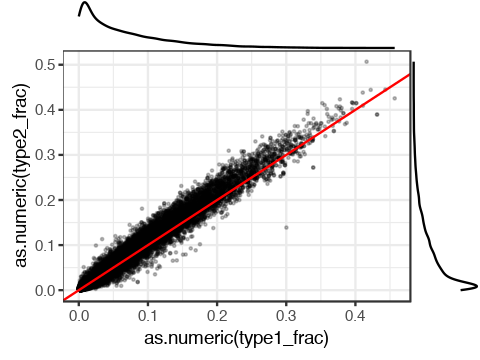

In [77]:
options(repr.plot.width=4, repr.plot.height=3)
res.genes_level.a.df <- tmp$beta
require(ggExtra)
p <- ggplot(res.genes_level.a.df, aes(as.numeric(type1_frac),
                                      as.numeric(type2_frac))) +
    geom_point(alpha=.25,size=.25) + theme_bw()+
    geom_abline(slope = 1,intercept = 0,color='red')
# add marginal histograms
ggExtra::ggMarginal(p, type = "density")

#### 2.4.2 Volcano plot

In [81]:
str(res.genes_level.a.df)

 NULL


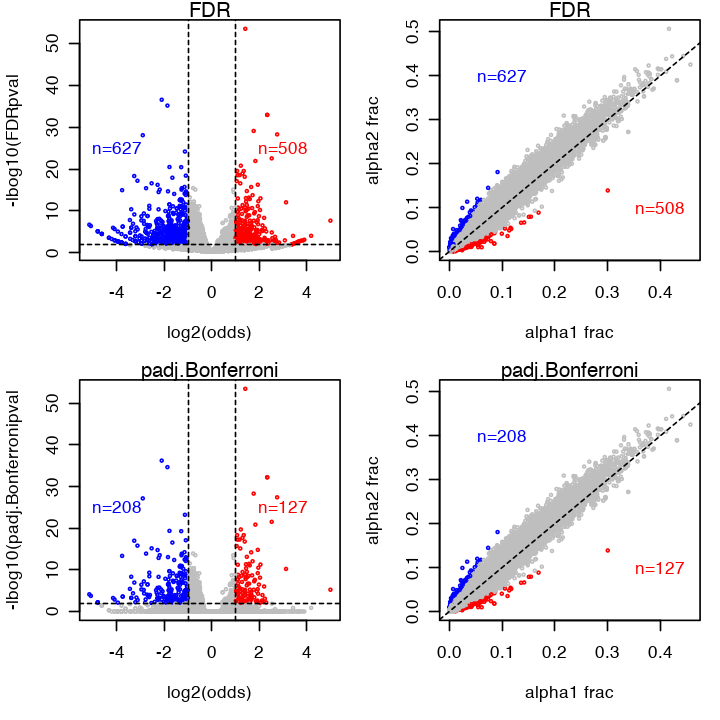

In [82]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
require(LSD)
res.genes_level.a.df <- tmp$beta
par(mar=c(5,4,1,1),mfrow = c(2,2))
for(m in c("FDR","padj.Bonferroni")){
    up<- res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)>1
    down<-res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)< -1
plot(x=log2(res.genes_level.a.df$odds),y=-log10(as.numeric(res.genes_level.a.df[,m])),
     xlab = "log2(odds)",ylab=paste0('-lbog10(',m,'pval'),cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(h = 2,col=1,lty=2)
abline(v=c(-1,1),col=1,lty=2)
text(-4,25,col='blue',labels = paste0("n=",sum(down)))
text(3,25,col='red',labels = paste0("n=",sum(up)))

# scatter 
plot(x=as.numeric(res.genes_level.a.df$type1_frac),y=as.numeric(res.genes_level.a.df$type2_frac),
     xlab = "alpha1 frac",ylab='alpha2 frac',cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(a=0,b = 1,col=1,lty=2)
text(.1,.4,col='blue',labels = paste0("n=",sum(down)))
text(.4,.1,col='red',labels = paste0("n=",sum(up)))
}



# MAplot
if(F){
    plot(y=log2(res.genes_level.a.df$odds),x=as.numeric(res.genes_level.a.df$type1_frac),
            ylab = "log2(odds)",xlab='apha1 frac',cex=.25,col='grey',pch=16,
            main = '')

    abline(h = c(-1,1),col=2,lty=2)

}

#ggplot(res.genes_level.a.df,aes(odds,-log10(FDR)))+geom_point()

### 2.5 GOterm analysis

In [105]:
require(enrichR)
alpha.glist <- list()
m<-"padj.Bonferroni"
    up<- res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)>1
    down<-res.genes_level.a.df[,m] <0.01 & log2(res.genes_level.a.df$odds)< -1

alpha.glist$alpha1<- sapply(rownames(res.genes_level.a.df)[up],function(x) unlist(strsplit(x,split = "_"))[1])
alpha.glist$alpha2<- sapply(rownames(res.genes_level.a.df)[down],function(x) unlist(strsplit(x,split = "_"))[1])
alpha.glist$alpha1 <- unique(alpha.glist$alpha1)
alpha.glist$alpha2 <- unique(alpha.glist$alpha2)
                            

In [106]:
    dbs<- c("GO_Biological_Process_2018","KEGG_2018")
    enriched <- enrichr(alpha.glist$alpha1, dbs)
    go.res.a <- list()
    go.res.a$alpha_1 <- enriched
    enriched[["GO_Biological_Process_2018"]]%>% 
        filter(Adjusted.P.value<0.5)%>%
        arrange(Adjusted.P.value)%>% 
        select(-starts_with("old"))
    


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of peptide hormone secretion (GO:0090276),5/74,0.0003177666,0.1016853,-1.840800,14.826156,ABCC8;GCG;KCNA5;GCK;SYT7
regulation of insulin secretion (GO:0050796),6/99,0.0001448144,0.1016853,-1.299263,11.485564,SLC30A8;ABCC8;GCG;KCNA5;GCK;SYT7
regulation of protein secretion (GO:0050708),6/108,0.0002331324,0.1016853,-1.269550,10.618398,RSAD2;ABCC8;GCG;KCNA5;GCK;SYT7
white fat cell differentiation (GO:0050872),2/7,0.0013009024,0.2065695,-3.001717,19.945503,CTBP2;CTBP1
atrial cardiac muscle cell to AV node cell signaling (GO:0086026),2/9,0.0022067678,0.2065695,-2.880422,17.617314,ANK2;KCNA5
positive regulation of ion transmembrane transporter activity (GO:0032414),3/24,0.0008988594,0.2065695,-2.495572,17.504899,ANK2;PDZK1;ATP1B1
regulation of organ growth (GO:0046620),2/10,0.0027439942,0.2065695,-2.908936,17.157898,WWC1;SLC6A4
negative regulation of activin receptor signaling pathway (GO:0032926),2/10,0.0027439942,0.2065695,-2.684052,15.831456,ACVR1;SKI
isoprenoid biosynthetic process (GO:0008299),2/9,0.0022067678,0.2065695,-2.531229,15.481571,MVK;PDSS1
isoprenoid metabolic process (GO:0006720),2/9,0.0022067678,0.2065695,-2.363020,14.452767,MVK;PDSS1


In [42]:
dbs <- listEnrichrDbs()
dbs%>%filter(grepl("Biological_Process",libraryName))

libraryName,numTerms,geneCoverage,genesPerTerm,link
GO_Biological_Process_2015,5192,14264,58,http://www.geneontology.org/GO.downloads.annotations.shtml
GO_Biological_Process_2013,941,7682,78,http://www.geneontology.org/GO.downloads.annotations.shtml
GO_Biological_Process_2017,3166,13822,21,http://www.geneontology.org/
GO_Biological_Process_2017b,10125,13247,49,http://www.geneontology.org/
GO_Biological_Process_2018,5103,14433,36,http://www.geneontology.org/


In [107]:
    enriched <- enrichr(alpha.glist$alpha2, dbs)
go.res.a$alpha2 <- enriched
enriched[["GO_Biological_Process_2018"]]%>% 
    filter(Adjusted.P.value<0.1)%>%
    arrange(Adjusted.P.value)%>% 
    select(-starts_with("old"))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
"positive regulation of transcription, DNA-templated (GO:0045893)",73/1121,7.328369e-05,0.09029085,-1.714432,16.32341,RNF10;CRTC2;SMARCB1;PTPRN;FHL2;PRDM2;YBX1;GPATCH3;TRIAP1;AATF;GLI3;WDR43;FLCN;ZNF609;TRIM28;ZC3H12A;ATXN7L3;HRAS;PITX3;KDM6B;NCOA1;SMARCC1;EBF4;POU3F1;ARID1B;NPAS4;TOX3;KARS;GPRIN1;RARA;MAPRE3;MET;ATF3;RHOQ;CREB5;NFAT5;HDAC5;CASZ1;KMT2A;SRF;FOXK2;ZNF24;RELA;RELB;RAI1;UBB;NUP85;TP53INP2;DVL1;UBC;HSF1;LEO1;HIVEP3;ZNF821;PPARGC1A;BCL9L;BRD4;CREBBP;XRCC6;ECD;HMGA1;FOXJ1;INHBA;MEIS2;HNRNPAB;FOSL2;NFKB2;FOSL1;MAVS;FUBP3;MAFF;SNAI1;SSBP3
regulation of G2/M transition of mitotic cell cycle (GO:0010389),17/150,1.558889e-04,0.09029085,-1.767119,15.49121,PSMD12;SSNA1;RCC2;NDE1;CKAP5;MECP2;CENPF;PSMA3;PSMA1;UBB;PSME3;UBC;PSMD3;PSMD1;DTL;PAFAH1B1;BRD4
regulation of type I interferon production (GO:0032479),13/86,4.892531e-05,0.09029085,-1.321196,13.11315,CREBBP;XRCC6;GPATCH3;RELA;NFKB2;MAVS;POLR3A;UBB;TRAF3;UBC;POLR3E;POLR1C;POLR2L
stimulatory C-type lectin receptor signaling pathway (GO:0002223),15/122,1.515031e-04,0.09029085,-1.350637,11.87872,CREBBP;PSMD12;RELA;RELB;PAK1;PSMA3;PSMA1;UBB;PSME3;UBC;PSMD3;PSMD1;TAB2;PAK3;HRAS
regulation of transcription from RNA polymerase II promoter in response to stress (GO:0043618),13/94,1.250712e-04,0.09029085,-1.296024,11.64689,CREBBP;PSMD12;BACH1;DNAJB1;PSMA3;PSMA1;UBB;PSME3;UBC;PSMD3;HSF1;PSMD1;ATF3
innate immune response activating cell surface receptor signaling pathway (GO:0002220),15/125,1.989707e-04,0.09603652,-1.466088,12.49452,CREBBP;PSMD12;RELA;RELB;PAK1;PSMA3;PSMA1;UBB;PSME3;UBC;PSMD3;PSMD1;TAB2;PAK3;HRAS
cAMP metabolic process (GO:0046058),6/25,4.367783e-04,0.09730077,-2.106753,16.29802,ADCY9;PDE4D;PDE2A;PDE4A;ADCY3;ADM
"transcription, DNA-templated (GO:0006351)",29/357,4.258059e-04,0.09730077,-1.864656,14.47258,NFAT5;GMEB2;GTF3C4;KMT2A;SRF;YBX2;YBX1;PWP1;TAF5L;POLR2A;TRIM29;DVL1;HSF1;LEO1;HIVEP3;POLR2L;NCOA1;ECD;DEK;MEIS2;FOSL1;POLR3A;FUBP3;MAFF;POLR1C;MED20;TAF5;PTMA;CREB5
intracellular transport of virus (GO:0075733),9/55,3.825078e-04,0.09730077,-1.541165,12.12706,POM121;NUP188;UBB;NUP85;NUP50;UBC;KPNA7;VPS37A;VPS37B
transport of virus (GO:0046794),9/55,3.825078e-04,0.09730077,-1.478072,11.63059,POM121;NUP188;UBB;NUP85;NUP50;UBC;KPNA7;VPS37A;VPS37B


In [348]:
save(file = './dat/1901/res.genes.a.all.rdata',list = c("go.res.a","alpha.glist"))